# Notebook for Catalog Selection of YSO Candidates

In [1]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import pyavm
import numpy as np
import PIL
import json
import requests
import asdf
import regions
from astropy import log
from astropy.io import ascii, fits
from astropy.wcs import WCS
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
from astropy.nddata import Cutout2D
import astropy.units as u

# do this before importing webb
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
from jwst.datamodels import ImageModel

from jwst.pipeline import calwebb_image3
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

from jwst.datamodels import ImageModel

import jwst.datamodels
from jwst import datamodels

In [2]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

In [3]:
cd /orange/adamginsburg/jwst/cloudc/analysis/

/blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis


In [4]:
%run analysis_setup.py

2024-03-05 15:11:24,181 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/analysis_setup.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import sys, imp

2024-03-05 15:11:24,183 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/analysis_setup.py:24: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus

2024-03-05 15:11:24,185 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/analysis_setup.py:24: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will 

I don't want to have to open these if I don't need to.
no daophot stuff done for cloud c yet...
For module nrca catalog crowdsource_nsky0_nrca_photometry_tables_merged.fits, mod date is 2024-01-24 14:23:03
For module nrcb catalog crowdsource_nsky0_nrcb_photometry_tables_merged.fits, mod date is 2024-01-24 15:51:35
For module merged catalog crowdsource_nsky0_merged_photometry_tables_merged.fits, mod date is 2024-01-24 12:47:43
For module merged-reproject catalog crowdsource_nsky0_merged-reproject_photometry_tables_merged.fits, mod date is 2024-01-24 16:53:51


In [5]:
%run selections.py

2024-03-05 15:11:40,833 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus

2024-03-05 15:11:40,835 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/brick-jwst-2221/analysis/selections.py:23: DeprecationWarning: `photutils.EPSFBuilder` is a deprecated alias for `photutils.psf.EPSFBuilder` and will be removed in the future. Instead, please use `from photutils.psf import EPSFBuilder` to silence this warning.
  from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus

2024-03-05 15:11:40,837 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/jwst/cloudc/code/bri

I don't want to have to open these if I don't need to.
no daophot stuff done for cloud c yet...
For module nrca catalog crowdsource_nsky0_nrca_photometry_tables_merged.fits, mod date is 2024-01-24 14:23:03
For module nrcb catalog crowdsource_nsky0_nrcb_photometry_tables_merged.fits, mod date is 2024-01-24 15:51:35
For module merged catalog crowdsource_nsky0_merged_photometry_tables_merged.fits, mod date is 2024-01-24 12:47:43
For module merged-reproject catalog crowdsource_nsky0_merged-reproject_photometry_tables_merged.fits, mod date is 2024-01-24 16:53:51
Selecting module merged

NRCA
3801 saturated in near_saturated_f212n_f212n
526 saturated in near_saturated_f466n_f466n
1091 saturated in near_saturated_f405n_f405n
3227 saturated in near_saturated_f187n_f187n
5626 saturated in near_saturated_f182m_f182m
10992 near saturated out of 568994.  That leaves 558002 not near unsaturated
249 saturated in replaced_saturated_f212n
61 saturated in replaced_saturated_f466n
102 saturated in repla

# Helper Functions

In [6]:
def get_cutout(filename, position, l, w):
    try: 
        hdu = fits.open(filename, ext='SCI')[0]
    except: 
        hdu = fits.open(filename)[0]
    data = hdu.data
    head = hdu.header

    #pixel_scale = head['PIXSCALE']*u.arcsec/u.pix
    ww = WCS(head)
    size = (l, w)
    #((l/pixel_scale).to(u.pix), (w/pixel_scale).to(u.pix))
    cutout = Cutout2D(data, position=position, size=size, wcs=ww)
    return cutout
'''
rgb_withstars = np.array(
      [
       fits.getdata(rgb[0]),
       fits.getdata(rgb[1]),
      ]
    ).swapaxes(0,2).swapaxes(0,1)
narrowsum_withstars = rgb_withstars[:,:,0] + rgb_withstars[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb_withstars[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb_withstars[:,:,0]),
                       simple_norm(narrowsum_withstars,  stretch='asinh', min_cut=-2, max_cut=210)(narrowsum_withstars),
                       simple_norm(rgb_withstars[:,:,1], stretch='asinh', min_cut=-1, max_cut=120)(rgb_withstars[:,:,1]),
]).swapaxes(0,2).swapaxes(0,1)
rgb = [
        f'{basepath}/images/{filternames[0][:-1].upper()}_reproj_{module}-fortricolor.fits',
        f'{basepath}/images/{filternames[1][:-1].upper()}_reproj_{module}-fortricolor.fits',
        ]
'''

def get_cutout_rgb(position, l, w):
    #filename_R = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    filename_R = '/orange/adamginsburg/jwst/cloudc/images/F466_reproj_merged-fortricolor.fits'
    #filename_B = '/orange/adamginsburg/jwst/cloudc/images/F187_reproj_merged-fortricolor.fits'
    filename_B = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    cutout_R = get_cutout(filename_R, position, l, w)
    cutout_B = get_cutout(filename_B, position, l, w)
    cutout_G = cutout_R.data + cutout_B.data
    rgb = np.array(
        [
            cutout_R.data,
            cutout_G,
            cutout_B.data
        ]
    ).swapaxes(0,2).swapaxes(0,1)
    rgb_scaled = np.array([
        simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,0]),
        simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=210)(rgb[:,:,1]),
        simple_norm(rgb[:,:,2], stretch='asinh', min_cut=-1, max_cut=120)(rgb[:,:,2]),
    ]).swapaxes(0,2)
    return rgb_scaled.swapaxes(0,1), cutout_R.wcs

 
#crds_in = crds_ab[reg.contains(crds_ab, wcs=ww_1)]

In [7]:
ref_tbl = Table.read(f'{basepath}/catalogs/crowdsource_based_nircam-f405n_reference_astrometric_catalog.ecsv')
crds_ref = ref_tbl['skycoord']

In [8]:
#position = SkyCoord('17:46:21.4695266413', '-28:35:38.2082071644', unit=(u.hourangle, u.deg))
position = SkyCoord('17:46:20.55', '-28:35:28', unit=(u.hourangle, u.deg))
l = 0.1 * u.arcmin
w = 0.1 * u.arcmin
rgb, ww = get_cutout_rgb(position, l, w)
reg_cloudc = regions.RectangleSkyRegion(center=position, width=l, height=w)
crds_in = crds_ref[reg_cloudc.contains(crds_ref, wcs=ww)]

2024-03-05 15:12:11,466 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


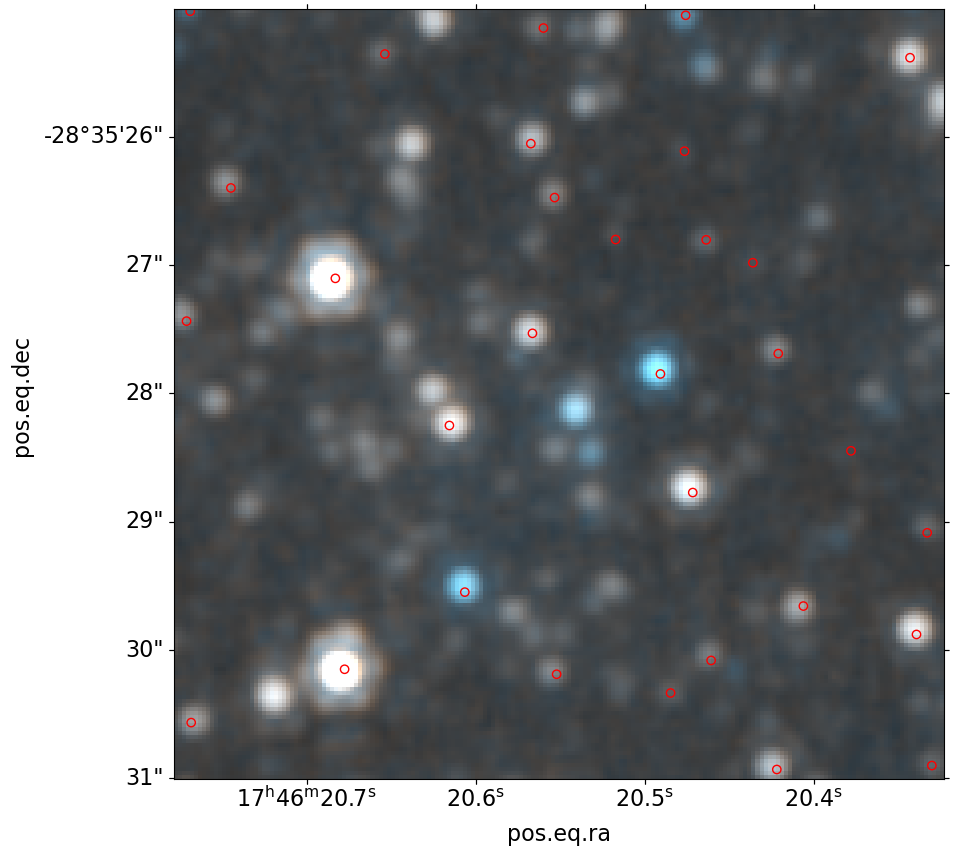

In [9]:
plt.figure(figsize=(24,10))
ax = plt.subplot(111, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))
plt.xticks([]);
plt.yticks([]);

# Color Cut Diagrams

In [ ]:
tbl_uses = basetable
#[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, c=tbl_uses_in['qf_f405n'], facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], tbl_uses['mag_ab_f410m'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], tbl_uses_in['mag_ab_f410m'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')

col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n']<-0.5]
ax_2.scatter(col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'], col_select['mag_ab_f410m'] - col_select['mag_ab_f466n'], label='bluer', marker='x', color='red')
ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='blue', facecolor='none', transform=ax.get_transform('world'))

ax_2.axvline(-0.5, color='k', ls='--')

ax_2.legend()
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F405N - F466N')
ax_2.set_ylabel('F410M - F466N')

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='orange', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], tbl_uses['mag_ab_f410m'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], tbl_uses_in['mag_ab_f410m'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')

col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n']<-0.5]
ax_2.scatter(col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'], col_select['mag_ab_f410m'] - col_select['mag_ab_f466n'], label='bluer', marker='x', color='red')
ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='blue', facecolor='none', transform=ax.get_transform('world'))

ax_2.axvline(-0.5, color='k', ls='--')


# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F405N - F466N')
ax_2.set_ylabel('F410M - F466N')
ax_2.legend()
#plt.gca().invert_yaxis()
print()

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='orange', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
#ax_2.scatter(tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], tbl_uses['mag_ab_410m405'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], tbl_uses_in['mag_ab_410m405'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')

col_select = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong) & veryblue_410m405_466] #tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n']<-0.5]
col_select_crds = col_select['skycoord_ref']
col_uses_in = col_select[reg_cloudc.contains(col_select_crds, wcs=ww)]
ax_2.scatter(col_uses_in['mag_ab_f405n'] - col_uses_in['mag_ab_f466n'], col_uses_in['mag_ab_410m405'] - col_uses_in['mag_ab_f466n'], label='bluer', marker='x', color='red')
ax.scatter(col_uses_in['skycoord_ref'].ra, col_uses_in['skycoord_ref'].dec, edgecolor='blue', facecolor='none', transform=ax.get_transform('world'))

#ax_2.axvline(-0.5, color='k', ls='--')


# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F405N - F466N')
ax_2.set_ylabel('F410MmF405N - F466N')
ax_2.legend()
#plt.gca().invert_yaxis()
print()

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='orange', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
#ax_2.scatter(tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], tbl_uses['mag_ab_410m405'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f466n'], tbl_uses_in['mag_ab_410m405'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')

col_select = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong) & veryblue_410m405_466] #tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n']<-0.5]
col_select_crds = col_select['skycoord_ref']
col_uses_in = col_select[reg_cloudc.contains(col_select_crds, wcs=ww)]
ax_2.scatter(col_uses_in['mag_ab_f187n'] - col_uses_in['mag_ab_f466n'], col_uses_in['mag_ab_410m405'] - col_uses_in['mag_ab_f466n'], label='bluer', marker='x', color='red')
ax.scatter(col_uses_in['skycoord_ref'].ra, col_uses_in['skycoord_ref'].dec, edgecolor='blue', facecolor='none', transform=ax.get_transform('world'))

ax_2.axvline(3, color='k', ls='--')


# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F187N - F466N')
ax_2.set_ylabel('F410MmF405N - F466N')
ax_2.legend()
#plt.gca().invert_yaxis()
print()

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], tbl_uses['mag_ab_f410m'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], tbl_uses_in['mag_ab_f410m'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F405N - F466N')
ax_2.set_ylabel('F410M - F466N')
ax_2.legend()
#plt.gca().invert_yaxis()
plt.xlim(right=2)
print()

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f212n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f212n'], label='in reg')
#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F405N - F466N')
ax_2.set_ylabel('F187N - F212N')
ax_2.legend()
#plt.gca().invert_yaxis()
print()

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='r', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f405n'], tbl_uses['mag_ab_f212n'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'], tbl_uses_in['mag_ab_f212n'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F187N - F405N')
ax_2.set_ylabel('F212N - F466N')
ax_2.legend()
#plt.gca().invert_yaxis()
print()

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='orange', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f405n'], tbl_uses['mag_ab_f187n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'], tbl_uses_in['mag_ab_f187n'], label='in reg')

col_select = tbl_uses_in[tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n']>3.5]
ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f405n'], col_select['mag_ab_f187n'], label='redder', marker='x', color='red')
ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))


#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F187N - F405N')
ax_2.set_ylabel('F187N')
ax_2.legend()
ax_2.axvline(3.5, color='k', ls='--')
plt.gca().invert_yaxis()
print()

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='orange', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f405n'], tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'], tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], label='in reg')


col_select = tbl_uses_in[tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'] > 3.5]
col_select_select = col_select[col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'] < -0.5]
ax_2.scatter(col_select_select['mag_ab_f187n'] - col_select_select['mag_ab_f405n'], col_select_select['mag_ab_f405n'] - col_select_select['mag_ab_f466n'], 
             label='redder and bluer', marker='x', color='purple')
ax.scatter(col_select_select['skycoord_ref'].ra, col_select_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'] < -0.5]
#ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f405n'], col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'], label='bluer', marker='+', color='blue')
#ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F187N - F405N')
ax_2.set_ylabel('F405N - F466N')

ax_2.axvline(3.5, color='k', ls='--')
ax_2.axhline(-0.5, color='k', ls='--')

ax_2.legend()
#plt.gca().invert_yaxis()
print()


In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='orange', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f405n'], tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'], tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], label='in reg')


col_select = tbl_uses_in[tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'] > 3.5]
col_select_select = col_select[col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'] < -0.5]

col_tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) 
                         & (~badfracfluxlong) & veryblue_410_466 
                         & (basetable['mag_ab_f187n'] - basetable['mag_ab_f466n'] > 3.5) 
                         & (basetable['mag_ab_f405n'] - basetable['mag_ab_f466n'] < -0.5)]
col_crds_uses = col_tbl_uses['skycoord_ref']

col_crds_in = col_crds_uses[reg_cloudc.contains(col_crds_uses, wcs=ww)]
col_tbl_uses_in = col_tbl_uses[reg_cloudc.contains(col_crds_uses, wcs=ww)]

ax_2.scatter(col_tbl_uses_in['mag_ab_f187n'] - col_tbl_uses_in['mag_ab_f405n'], col_tbl_uses_in['mag_ab_f405n'] - col_tbl_uses_in['mag_ab_f466n'], 
             label='redder and bluer', marker='x', color='purple')
ax.scatter(col_tbl_uses_in['skycoord_ref'].ra, col_tbl_uses_in['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'] < -0.5]
#ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f405n'], col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'], label='bluer', marker='+', color='blue')
#ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F187N - F405N')
ax_2.set_ylabel('F405N - F466N')

ax_2.axvline(3.5, color='k', ls='--')
ax_2.axhline(-0.5, color='k', ls='--')

ax_2.legend()
#plt.gca().invert_yaxis()
print()


In [ ]:
im = ImageModel('/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits')
data = im.data
wwww = im.get_fits_wcs()
plt.subplot(211, projection=wwww)
ax = plt.subplot(211, projection=wwww)#, origin='lower')
ax.imshow(np.nan_to_num(data), vmin=0, vmax=50)

In [ ]:
tbl_uses = basetable[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)& veryblue_410_466 
                     & (basetable['mag_ab_f187n'] - basetable['mag_ab_f466n'] > 3.5) 
                     & (basetable['mag_ab_f405n'] - basetable['mag_ab_f466n'] < -0.5)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
im = ImageModel('/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits')
data = im.data
wwww = im.get_fits_wcs()
ax = plt.subplot(111, projection=wwww)#, origin='lower')
ax.imshow(np.nan_to_num(data), vmin=0, vmax=50)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#ax_2 = plt.subplot(212)
#ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f405n'], tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], label='all')
#ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'], tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
#
##col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'] < -0.5]
##ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f405n'], col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'], label='bluer', marker='+', color='blue')
##ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))
#
##ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
## [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
#ax_2.set_xlabel('F187N - F405N')
#ax_2.set_ylabel('F405N - F466N')
#
#ax_2.axvline(3.5, color='k', ls='--')
#ax_2.axhline(-0.5, color='k', ls='--')
#
#ax_2.legend()
#plt.gca().invert_yaxis()
print()


In [ ]:
tbl_uses = basetable[(~badqflong) & veryblue_410_466 
                     & (basetable['mag_ab_f187n'] - basetable['mag_ab_f466n'] > 3.5) 
                     & (basetable['mag_ab_f405n'] - basetable['mag_ab_f466n'] < -0.5)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
im = ImageModel('/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits')
data = im.data
wwww = im.get_fits_wcs()
ax = plt.subplot(111, projection=wwww)#, origin='lower')
ax.imshow(np.nan_to_num(data), vmin=0, vmax=50)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#ax_2 = plt.subplot(212)
#ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f405n'], tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], label='all')
#ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'], tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], label='in reg')
#
##col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'] < -0.5]
##ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f405n'], col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'], label='bluer', marker='+', color='blue')
##ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))
#
##ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
## [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
#ax_2.set_xlabel('F187N - F405N')
#ax_2.set_ylabel('F405N - F466N')
#
#ax_2.axvline(3.5, color='k', ls='--')
#ax_2.axhline(-0.5, color='k', ls='--')
#
#ax_2.legend()
#plt.gca().invert_yaxis()
print()


In [ ]:
tbl_uses = basetable[blue_BrA_and_PaA]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='orange', facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f405n'], tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f466n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'], tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'], label='in reg')


col_select = tbl_uses_in[tbl_uses_in['mag_ab_f187n'] - tbl_uses_in['mag_ab_f405n'] > 3.5]
col_select_select = col_select[col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'] < -0.5]
ax_2.scatter(col_select_select['mag_ab_f187n'] - col_select_select['mag_ab_f405n'], col_select_select['mag_ab_f405n'] - col_select_select['mag_ab_f466n'], 
             label='redder and bluer', marker='x', color='purple')
ax.scatter(col_select_select['skycoord_ref'].ra, col_select_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n'] < -0.5]
#ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f405n'], col_select['mag_ab_f405n'] - col_select['mag_ab_f466n'], label='bluer', marker='+', color='blue')
#ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

#ax_2.plot([-2, 1.5], [-2, 1.5], color='k')
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F187N - F405N')
ax_2.set_ylabel('F405N - F466N')

ax_2.axvline(3.5, color='k', ls='--')
ax_2.axhline(-0.5, color='k', ls='--')

ax_2.legend()
#plt.gca().invert_yaxis()
print()


In [ ]:
plt.scatter(tbl_uses['mag_ab_405m410'], tbl_uses['mag_ab_187m182'], label='all')
plt.scatter(tbl_uses_in['mag_ab_405m410'], tbl_uses_in['mag_ab_187m182'], label='in reg')
plt.scatter(col_select_select['mag_ab_405m410'], col_select_select['mag_ab_187m182'], label='color-selected')
plt.xlabel('Continuum Subtracted F405N')
plt.ylabel('Continuum Subtracted F187N')
plt.legend()

In [ ]:
less_oksep = np.logical_and.reduce([basetable[f'sep_{filtername}'] < 0.1*u.arcsec for filtername in filternames[1:]])

In [ ]:
tbl_uses = basetable[(basetable['qf_f405n']>0.6)]# & long_good]# & less_oksep]
#[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, c=tbl_uses_in['qf_f405n'], facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f410m'], tbl_uses['mag_ab_f405n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f410m'], tbl_uses_in['mag_ab_f405n'], label='in reg')
ax_2.plot([7.5, 22.5], [7.5, 22.5], color='k')
ax_2.plot([7.5, 22.5], [9.5, 24.5], color='k', ls='--')
ax_2.plot([7.5, 22.5], [5.5, 20.5], color='k', ls='--')

col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n']-tbl_uses_in['mag_ab_f410m'] < -2]
#col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n']<-0.5]
ax_2.scatter(col_select['mag_ab_f410m'], col_select['mag_ab_f405n'], label='excess Br alpha', marker='x', color='red')
ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, marker='x', color='red', transform=ax.get_transform('world'))
#ax_2.scatter(col_select['mag_ab_f405n'], col_select['mag_ab_f410m'], label='bluer', marker='x', color='red')
#ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, edgecolor='blue', facecolor='none', transform=ax.get_transform('world'))
#ax_2.axvline(-0.5, color='k', ls='--')

ax_2.legend()
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F410M')
ax_2.set_ylabel('F405N')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [ ]:
tbl_uses = basetable[(basetable['qf_f405n']>0.6)]# & long_good]# & less_oksep]
#[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, c=tbl_uses_in['qf_f405n'], facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f182m'], tbl_uses['mag_ab_f187n'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f182m'], tbl_uses_in['mag_ab_f187n'], label='in reg')
ax_2.plot([7.5, 22.5], [7.5, 22.5], color='k')
ax_2.plot([7.5, 22.5], [9.5, 24.5], color='k', ls='--')
ax_2.plot([7.5, 22.5], [5.5, 20.5], color='k', ls='--')

col_select = tbl_uses_in[tbl_uses_in['mag_ab_f187n']-tbl_uses_in['mag_ab_f182m'] < -2]
#col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n'] - tbl_uses_in['mag_ab_f466n']<-0.5]
ax_2.scatter(col_select['mag_ab_f182m'], col_select['mag_ab_f187n'], label='excess Pa alpha', marker='x', color='red')
ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, marker='x', color='red', transform=ax.get_transform('world'))
#ax_2.axvline(-0.5, color='k', ls='--')

ax_2.legend()
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F182M')
ax_2.set_ylabel('F187N')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

2024-03-05 15:13:09,710 - stpipe - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0, 0.5, 'F405N - F410M')

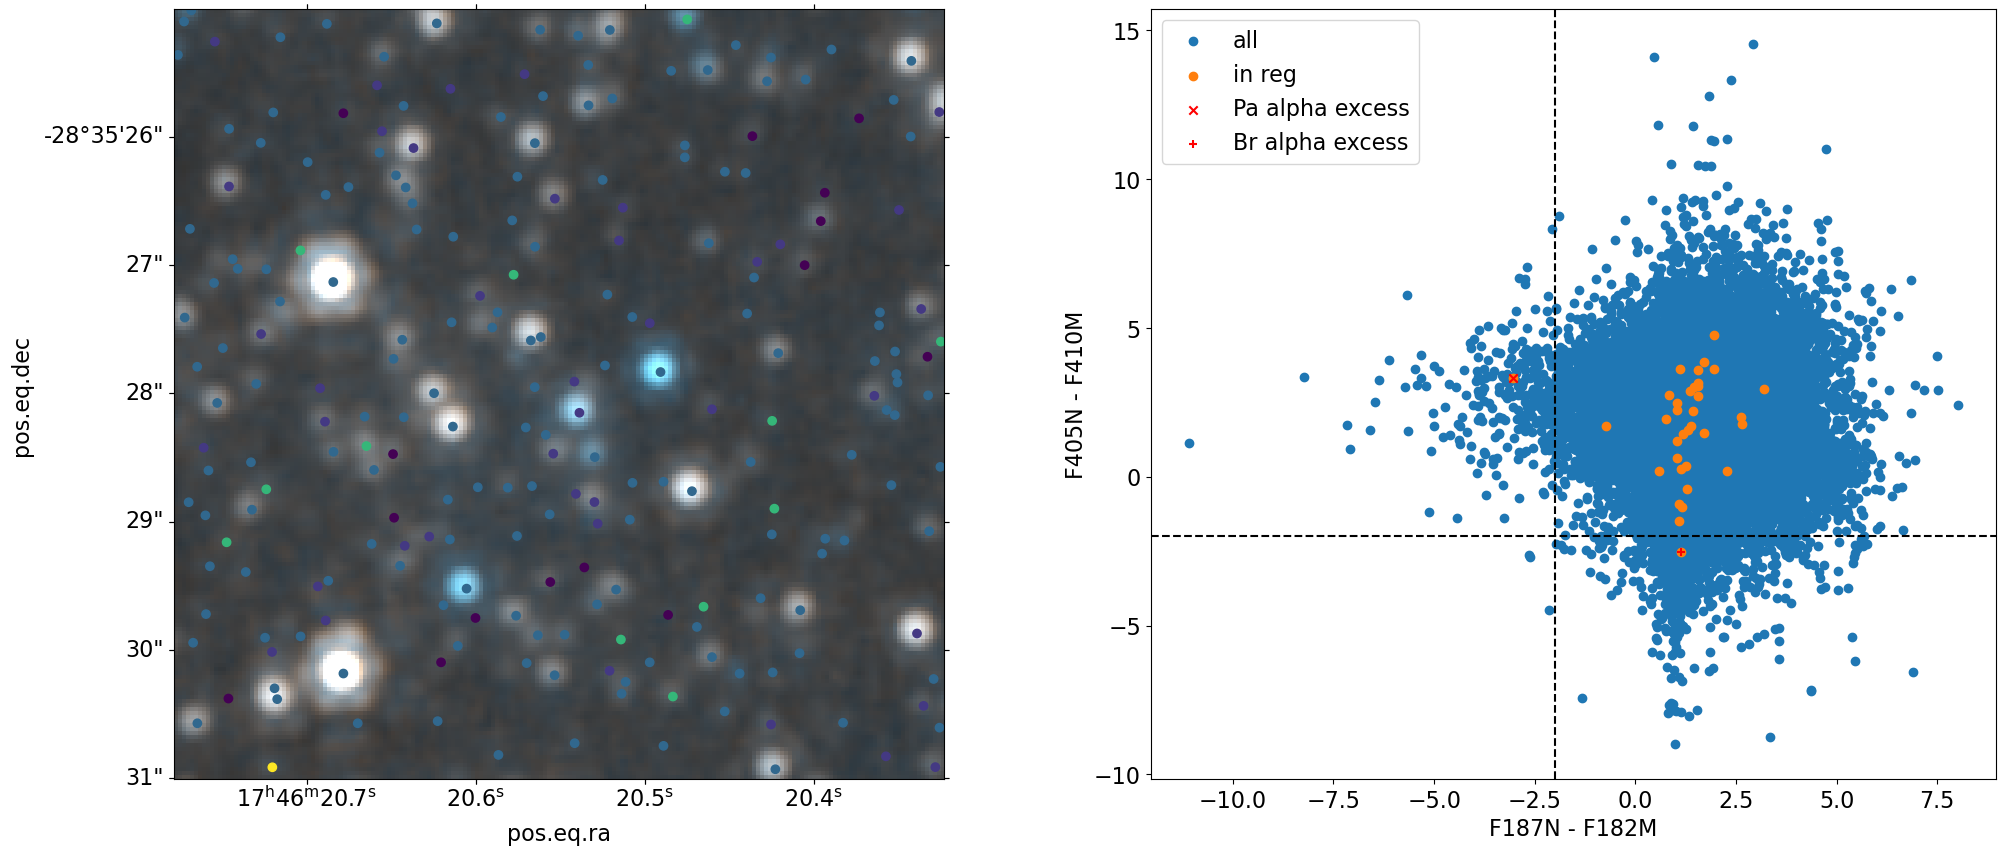

In [13]:
tbl_uses = basetable[(basetable['qf_f405n']>0.6)]# & long_good]# & less_oksep]
#[oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
ax = plt.subplot(121, projection=ww)#, origin='lower')
ax.imshow(rgb)
ax.scatter(crds_in.ra, crds_in.dec, c=tbl_uses_in['qf_f405n'], facecolor='none', transform=ax.get_transform('world'))

ax_2 = plt.subplot(122)
ax_2.scatter(tbl_uses['mag_ab_f187n'] - tbl_uses['mag_ab_f182m'], tbl_uses['mag_ab_f405n'] - tbl_uses['mag_ab_f410m'], label='all')
ax_2.scatter(tbl_uses_in['mag_ab_f187n'] -tbl_uses_in['mag_ab_f182m'], tbl_uses_in['mag_ab_f405n'] -tbl_uses_in['mag_ab_f410m'], label='in reg')
#ax_2.plot([7.5, 22.5], [7.5, 22.5], color='k')
#ax_2.plot([7.5, 22.5], [9.5, 24.5], color='k', ls='--')
#ax_2.plot([7.5, 22.5], [5.5, 20.5], color='k', ls='--')

col_select = tbl_uses_in[tbl_uses_in['mag_ab_f187n']-tbl_uses_in['mag_ab_f182m'] < -2]
#col_select = col_select[col_select['mag_ab_f405n'] - col_select['mag_ab_f466n']<-2]
ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f182m'], col_select['mag_ab_f405n'] - col_select['mag_ab_f410m'], label='Pa alpha excess', marker='x', color='red')
#ax.scatter(col_select['skycoord_ref'].ra, col_select['skycoord_ref'].dec, marker='x', color='red', transform=ax.get_transform('world'))
ax_2.axvline(-2, color='k', ls='--')
ax_2.axhline(-2, color='k', ls='--')

col_select = tbl_uses_in[tbl_uses_in['mag_ab_f405n']-tbl_uses_in['mag_ab_f410m'] < -2]
#col_select = col_select[col_select['mag_ab_f405n'] - col_select['mag_ab_f466n']<-2]
ax_2.scatter(col_select['mag_ab_f187n'] - col_select['mag_ab_f182m'], col_select['mag_ab_f405n'] - col_select['mag_ab_f410m'], label='Br alpha excess', marker='+', color='red')
#

ax_2.legend()
# [('f410m', 'f466n'), ('f410m', 'f405n'), ('f405n', 'f466n'), ('410m405', 'f405n')]
ax_2.set_xlabel('F187N - F182M')
ax_2.set_ylabel('F405N - F410M')
#plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

In [ ]:
tbl_uses = basetable[(~badqflong) #& veryblue_410_466 
                     & (basetable['mag_ab_f187n'] - basetable['mag_ab_f182m'] < -1.) 
                     & (basetable['mag_ab_f405n'] - basetable['mag_ab_f410m'] < -1.)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
im = ImageModel('/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits')
data = im.data
wwww = im.get_fits_wcs()
ax = plt.subplot(111, projection=wwww)#, origin='lower')
ax.imshow(np.nan_to_num(data), vmin=0, vmax=50)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

2024-03-05 15:15:48,772 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-15T15:08:19.262' from MJD-BEG.
Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'.
  warnings.warn(

2024-03-05 15:15:48,779 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.380275 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'.
  warnings.warn(



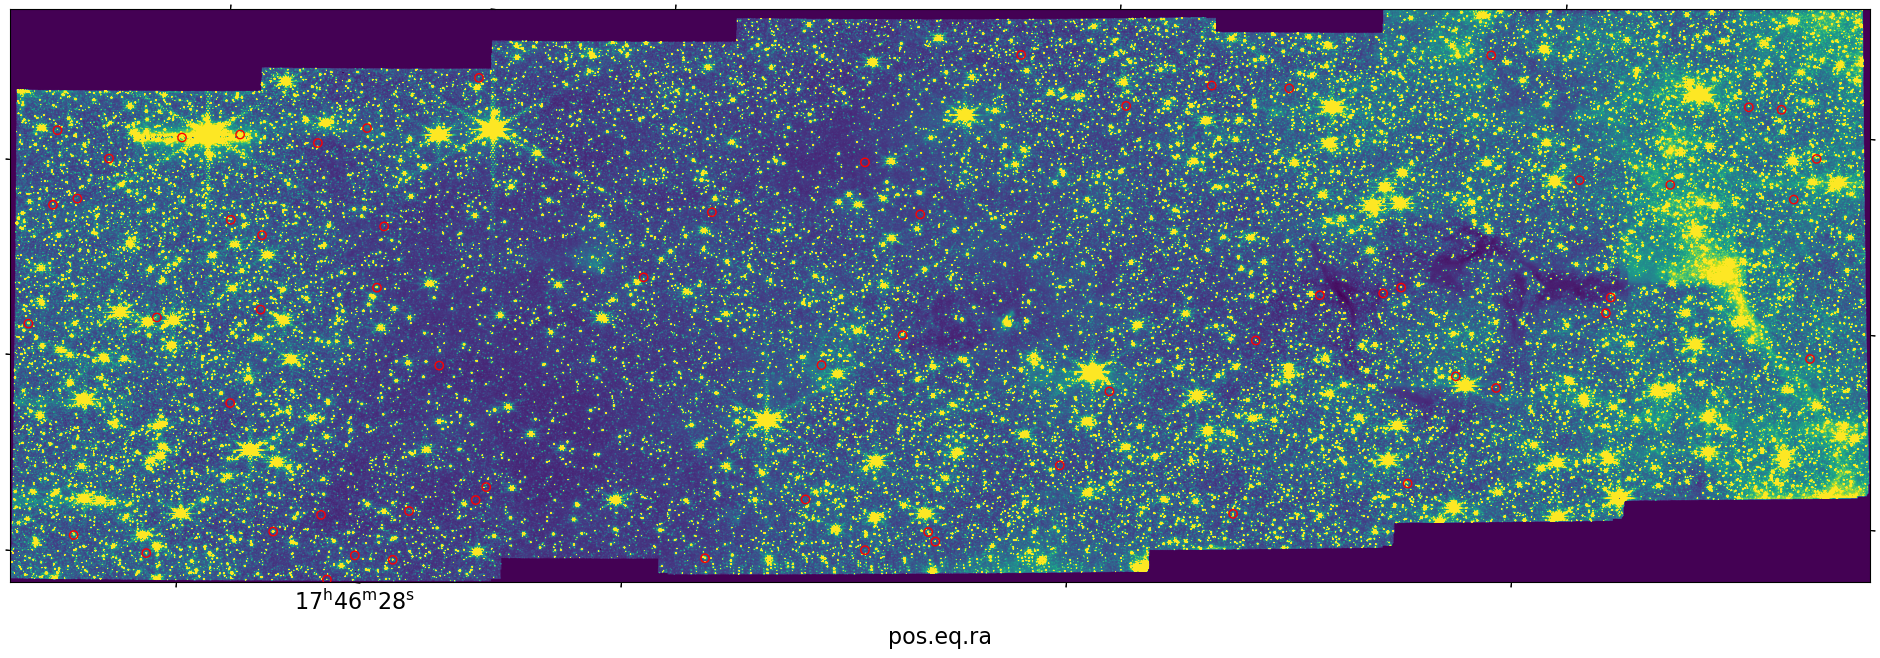

In [16]:
tbl_uses = basetable[#(~badqflong) #& veryblue_410_466 
                     (basetable['mag_ab_f187n'] - basetable['mag_ab_f182m'] < -.5) 
                     & (basetable['mag_ab_f405n'] - basetable['mag_ab_f410m'] < -.5)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
im = ImageModel('/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits')
data = im.data
wwww = im.get_fits_wcs()
ax = plt.subplot(111, projection=wwww)#, origin='lower')
ax.imshow(np.nan_to_num(data), vmin=0, vmax=50)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

2024-03-05 15:16:07,912 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-15T15:08:19.262' from MJD-BEG.
Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'.
  warnings.warn(

2024-03-05 15:16:07,915 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.380275 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'.
  warnings.warn(



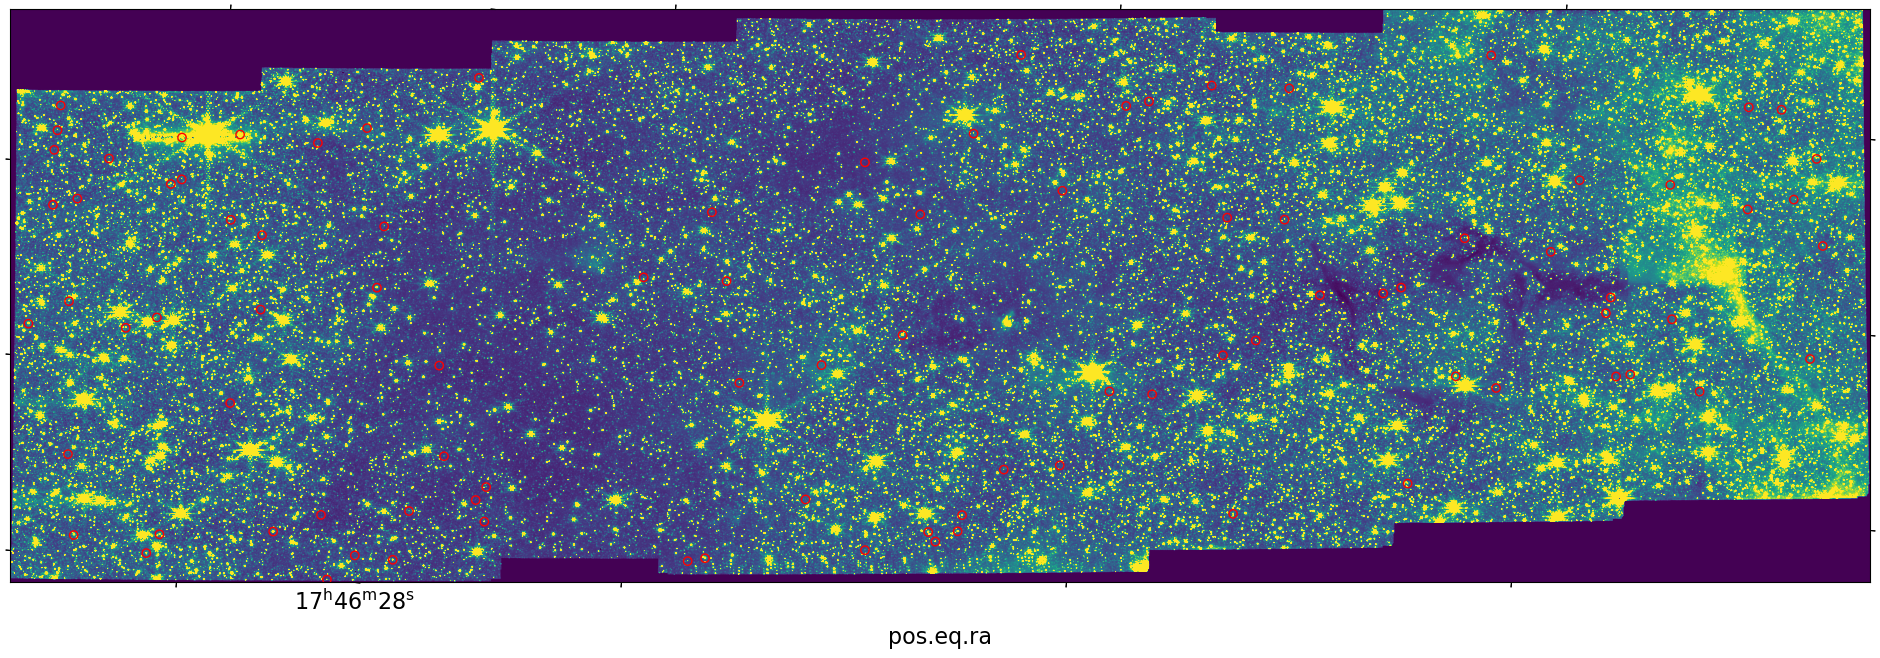

In [17]:
tbl_uses = basetable[#(~badqflong) #& veryblue_410_466 
                      (basetable['mag_ab_f187n'] - basetable['mag_ab_f182m'] < -.25) 
                     & (basetable['mag_ab_f405n'] - basetable['mag_ab_f410m'] < -.25)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
im = ImageModel('/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits')
data = im.data
wwww = im.get_fits_wcs()
ax = plt.subplot(111, projection=wwww)#, origin='lower')
ax.imshow(np.nan_to_num(data), vmin=0, vmax=50)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

In [ ]:
tbl_uses = basetable[#(~badqflong) #& veryblue_410_466 
                      (basetable['mag_ab_f187n'] - basetable['mag_ab_f182m'] < -.1) 
                     & (basetable['mag_ab_f405n'] - basetable['mag_ab_f410m'] < -.1)]
crds_uses = tbl_uses['skycoord_ref']

crds_in = crds_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]
tbl_uses_in = tbl_uses#[reg_cloudc.contains(crds_uses, wcs=ww)]

plt.figure(figsize=(24,10))
im = ImageModel('/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits')
data = im.data
wwww = im.get_fits_wcs()
ax = plt.subplot(111, projection=wwww)#, origin='lower')
ax.imshow(np.nan_to_num(data), vmin=0, vmax=50)
ax.scatter(crds_in.ra, crds_in.dec, edgecolor='red', facecolor='none', transform=ax.get_transform('world'))

2024-03-05 15:16:20,488 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-15T15:08:19.262' from MJD-BEG.
Set DATE-AVG to '2023-04-20T10:07:44.724' from MJD-AVG.
Set DATE-END to '2023-04-25T05:06:53.406' from MJD-END'.
  warnings.warn(

2024-03-05 15:16:20,498 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:807: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -134.380275 from OBSGEO-[XYZ].
Set OBSGEO-B to    -3.177752 from OBSGEO-[XYZ].
Set OBSGEO-H to 1298809712.873 from OBSGEO-[XYZ]'.
  warnings.warn(



# Plot Tools Stuff

In [ ]:
import plot_tools

In [ ]:
stats = plot_tools.xmatch_plot(basetable, sel=(oksep & ~any_saturated & ~magerr_gtpt1 & (~badqflong) & (~badspreadlong) & (~badfracfluxlong)), 
                               axlims=[-0.2,0.2,-0.2,0.2], maxsep=0.2*u.arcsec,
                               regs=['cloudc_nrca.reg', 'cloudc_nrcb.reg'], 
                               ref_filter='f405n', obsid='002', module='merged', save_output=True)

In [ ]:
pwd